# Example use of the Julia module Sonic.Linckii

In [25]:
import Pkg                      # package manager
Pkg.activate("..")              # Project.toml
Pkg.instantiate()               # https://julialang.github.io/Pkg.jl/v1.0/index.html
include("../src/Sonic.jl")      # project main module

Activating environment at `~/Documents/Calendar/Work/Noda/Code/Sonic.jl/Project.toml`


Main.Sonic

Note that the module depends on LinckiiSecrets for authentication, which is not part of the Git repository, and has to be added by hand.

In [2]:
include("../src/LinckiiSecrets.jl")
access = Sonic.Linckii.get_access(LinckiiSecrets.keab)

(url = "https://canary.noda.se/~keab", key = "e86d93131e6bc12ae701d036e696cf8b")

In [3]:
import Dates, JuliaDB, Plots, Random

GET "https://canary.noda.se/$site_name/api/v1/node"

In [4]:
@time nodes = Sonic.Linckii.get_nodes(access)

 31.486890 seconds (31.79 M allocations: 1.942 GiB, 2.16% gc time)


Table with 279 rows, 8 columns:
Columns:
#  colname           type
─────────────────────────────────
1  node_public       Bool
2  node_name         String
3  device_id         Int64
4  node_id           Int64
5  node_owner        Bool
6  node_enabled      Bool
7  sensor_ids        Array{Any,1}
8  node_description  String

GET "https://canary.noda.se/$site_name/api/v1/device"

In [5]:
@time devices = Sonic.Linckii.get_devices(access)

 16.165209 seconds (16.20 M allocations: 1.098 GiB, 1.95% gc time)


Table with 11 rows, 3 columns:
protocol_id  device_name             device_id
──────────────────────────────────────────────
1            "Kelp-IQHeat"           1
2            "Scout"                 2
1            "Kelp-Basic"            4
5            "Weather-Forecast"      6
6            "Grid-Basic"            7
6            "Grid-Controller"       8
7            "Heat-Load-Forecast"    9
2            "CMa1Xw"                10
2            "EcoGuard Sensor"       11
2            "WEPTech"               12
8            "Flexibility-Forecast"  13

GET "https://canary.noda.se/$site_name/api/v1/sensor"

In [6]:
@time sensors = Sonic.Linckii.get_sensors(access)

 34.489124 seconds (31.45 M allocations: 2.126 GiB, 1.85% gc time)


Table with 175 rows, 5 columns:
Columns:
#  colname             type
────────────────────────────────
1  sensor_unit         FreeUnits
2  sensor_name         Symbol
3  protocol_id         Int64
4  sensor_id           Int64
5  sensor_description  String

Save site,

In [15]:
Sonic.Linckii.savesite(access; nodes = nodes, devices = devices, sensors = sensors)

Load site,

In [28]:
nodes, devices, sensors = Sonic.Linckii.loadsite(access, :nodes, :devices, :sensors)

(nodes = Table with 279 rows, 8 columns:
Columns:
#  colname           type
─────────────────────────────────
1  node_public       Bool
2  node_name         String
3  device_id         Int64
4  node_id           Int64
5  node_owner        Bool
6  node_enabled      Bool
7  sensor_ids        Array{Any,1}
8  node_description  String, devices = Table with 11 rows, 3 columns:
protocol_id  device_name             device_id
──────────────────────────────────────────────
1            "Kelp-IQHeat"           1
2            "Scout"                 2
1            "Kelp-Basic"            4
5            "Weather-Forecast"      6
6            "Grid-Basic"            7
6            "Grid-Controller"       8
7            "Heat-Load-Forecast"    9
2            "CMa1Xw"                10
2            "EcoGuard Sensor"       11
2            "WEPTech"               12
8            "Flexibility-Forecast"  13, sensors = Table with 175 rows, 5 columns:
Columns:
#  colname             type
───────────────────

Get side 1 substation series,

In [7]:
signals = JuliaDB.reindex(
    JuliaDB.join(
        Sonic.Linckii.flatten_nodes(JuliaDB.filter(r -> r.device_id == 4, nodes)),
        JuliaDB.filter(
            r -> r.sensor_name in [
                :meter_effect,
                :meter_primreturntemp,
                :meter_primsupplytemp,
                :meter_volumeflow,
            ],
            sensors
        );
        lkey = :sensor_id,
        rkey = :sensor_id,
    ),
    (:node_id, :sensor_id),
)

Table with 361 rows, 12 columns:
Columns:
#   colname             type
──────────────────────────────
1   node_id             Int64
2   sensor_id           Int64
3   node_public         Bool
4   node_name           String
5   device_id           Int64
6   node_owner          Bool
7   node_enabled        Bool
8   node_description    String
9   sensor_unit         Any
10  sensor_name         Symbol
11  protocol_id         Int64
12  sensor_description  String

In [8]:
signal_rows = JuliaDB.rows(signals)
length(signal_rows)

361

Save series,

In [9]:
dates = [Dates.DateTime(yyyy, mm) for yyyy in 2016 : 2019 for mm in 1 : 12]

48-element Array{Dates.DateTime,1}:
 2016-01-01T00:00:00
 2016-02-01T00:00:00
 2016-03-01T00:00:00
 2016-04-01T00:00:00
 2016-05-01T00:00:00
 2016-06-01T00:00:00
 2016-07-01T00:00:00
 2016-08-01T00:00:00
 2016-09-01T00:00:00
 2016-10-01T00:00:00
 2016-11-01T00:00:00
 2016-12-01T00:00:00
 2017-01-01T00:00:00
 ⋮                  
 2019-01-01T00:00:00
 2019-02-01T00:00:00
 2019-03-01T00:00:00
 2019-04-01T00:00:00
 2019-05-01T00:00:00
 2019-06-01T00:00:00
 2019-07-01T00:00:00
 2019-08-01T00:00:00
 2019-09-01T00:00:00
 2019-10-01T00:00:00
 2019-11-01T00:00:00
 2019-12-01T00:00:00

In [10]:
if true
    signal_rows = [signal_rows[Random.rand(1 : end)]]
end
for r in signal_rows
    try
        Sonic.Linckii.savedata(access, r.node_id, r.sensor_name, dates...)
        println("$(Sonic.Linckii.datapath(access, r.node_id, r.sensor_name)): Done")
    catch e
        println("$(Sonic.Linckii.datapath(access, r.node_id, r.sensor_name)): $(e)")
    end
end

db/linckii/~keab/data/70/meter_primsupplytemp: Done


Load series,

In [11]:
r = signal_rows[Random.rand(1 : end)]
(r.node_id, r.sensor_name)

(70, :meter_primsupplytemp)

In [12]:
data = Sonic.Linckii.loaddata(access, r.node_id, r.sensor_name)

Table with 194432 rows, 3 columns:
datetime             timezone       value
─────────────────────────────────────────
2016-01-01T00:12:02  tz"UTC+01:00"  82.78
2016-01-01T00:22:04  tz"UTC+01:00"  82.63
2016-01-01T00:32:04  tz"UTC+01:00"  82.72
2016-01-01T00:42:02  tz"UTC+01:00"  82.96
2016-01-01T00:52:02  tz"UTC+01:00"  83.04
2016-01-01T01:02:03  tz"UTC+01:00"  82.48
2016-01-01T01:12:04  tz"UTC+01:00"  82.52
2016-01-01T01:22:04  tz"UTC+01:00"  82.8
2016-01-01T01:32:02  tz"UTC+01:00"  82.64
2016-01-01T01:42:02  tz"UTC+01:00"  82.74
2016-01-01T01:52:04  tz"UTC+01:00"  82.98
2016-01-01T02:02:04  tz"UTC+01:00"  82.83
⋮
2019-11-30T22:12:02  tz"UTC+01:00"  97.69
2019-11-30T22:22:03  tz"UTC+01:00"  97.75
2019-11-30T22:32:02  tz"UTC+01:00"  97.99
2019-11-30T22:42:03  tz"UTC+01:00"  97.72
2019-11-30T22:52:03  tz"UTC+01:00"  98.11
2019-11-30T23:02:02  tz"UTC+01:00"  98.44
2019-11-30T23:12:02  tz"UTC+01:00"  98.09
2019-11-30T23:22:02  tz"UTC+01:00"  98.49
2019-11-30T23:32:03  tz"UTC+01:00"  98.5

Simple plot,

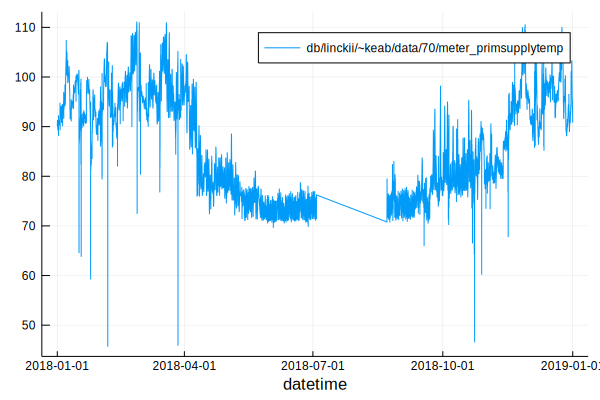

In [13]:
t = JuliaDB.filter(
    r -> r.datetime >= Dates.DateTime(2018) && r.datetime <= Dates.DateTime(2019),
    data,
)
x = JuliaDB.select(t, :datetime)
y = JuliaDB.select(t, :value)
Plots.plot(x, y, xlabel = :datetime, label = Sonic.Linckii.datapath(access, r.node_id, r.sensor_name))